In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
cd ./drive/My Drive/Colab Notebooks/EECS595/Final/data

/content/drive/My Drive/Colab Notebooks/EECS595/Final/data


In [4]:
ls

data-all-annotations/  glove.6B.100d.txt  glove.6B.50d.txt                 test.csv
data_test.csv          glove.6B.200d.txt  glove.6B.zip                     train.csv
data_train.csv         glove.6B.300d.txt  stance-data-all-annotations.zip


In [5]:
# Import necessary packages
import pandas as pd
import numpy as np
import chardet
import csv
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.models import Sequential
from keras import backend as K
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud, STOPWORDS
from tensorflow.keras.optimizers import Adam
from multiprocessing import Pool
import dask.dataframe as dd

In [6]:
# Download necessary nltk packages
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Function to display the word cloud of each target tweet
def plot_word_cloud(string):
    wcloud = WordCloud(background_color = "white", max_words = 50, stopwords = set(STOPWORDS)).generate(string)
    plt.imshow(wcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [ ]:
# Function to process/clean the tweets
pun = """!"$%&'()*+,-./:;<=>?[\]^`{|}~"""
stop_words = set(stopwords.words('english'))
def tweet_data_preprocess(tweet):
    tags = []
    tweet= tweet.lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    #remove non ascii
    encoded_string = tweet.encode("ascii", "ignore")
    tweet = encoded_string.decode()
    # split continuous hashSymbols and @references
    tweet = re.sub(r'\#',' #', tweet)
    tweet = re.sub(r'\@',' @', tweet)
    # Replace punctuations with white space
    tweet = tweet.translate(str.maketrans(pun, ' '*len(pun)))
    # extract the hashtags
    a = ''.join(filter(lambda x: x in string.printable, tweet))

    for tweet_it in a.split(' '):
        if tweet_it.startswith('#'):
            tags.append(tweet_it.strip(','))

    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+','', tweet)
    tweet = re.sub(r'\#\w+','', tweet)
    #remove numbers
    digits = '[0-9]'
    tweet = re.sub(digits, '', tweet)
    #remove reserved words
    tweet = re.sub(" rt "," ",tweet)
    tweet = re.sub(" fav "," ",tweet)
    #remove words of less than  three chars
    tweet = re.sub(r'\b\w{1,2}\b', '',tweet)
     #Remove emojis
    tweet = re.sub('(?::|;|=)(?:-)?(?:\)|\(|D|P)'," ",tweet)
    #remove extra space
    tweet = re.sub(r"\s+"," ",tweet)
    # Remove stopwords
    sp = spacy.load('en_core_web_sm')
    sentence = sp(tweet)
    tweet_tokens  = [i.lemma_ if i.lemma_ != '-PRON-' else i.lower_ for i in sentence]
    filtered = [w for w in tweet_tokens if not w in stop_words]
    filtered = ' '.join(filtered).split()
    for it in tags:
        filtered.append(it)
    return " ".join(filtered)

In [ ]:
def load_dataframe(file_path):
  with open(file_path, 'rb') as f:
    result = chardet.detect(f.read())
    file_encoding = result['encoding']
  tweet = []
  target = []
  stance = []
  opinion = []
  sentiment = []
  # Open the CSV file using a with statement
  with open(file_path, 'r', encoding=file_encoding) as file:
    reader = csv.reader(file)

    # Process each row in the CSV file
    for row in reader:
    # Do something with the row, e.g., print it
      tweet.append(row[0])
      target.append(row[1])
      stance.append(row[2])
      opinion.append(row[3])
      sentiment.append(row[4])
  df = pd.DataFrame({'Tweet': tweet, 'Target': target, 'Stance': stance, 'Opinion': opinion, 'Sentiment': sentiment})
  df=df.drop(0,axis=0).reset_index(drop=True)
  # stance2label = {'AGAINST': 0, 'FAVOR': 2, 'NONE': 1}
  # df['label'] = df['Stance'].map(stance2label)
  return df

In [ ]:
# # Load train and test data
# data_train = pd.read_csv('data-all-annotations/trainingdata-all-annotations.txt', sep='\t', encoding='ISO-8859-1')
# data_test = pd.read_csv('data-all-annotations/trainingdata-all-annotations.txt', sep='\t', encoding='ISO-8859-1')
# data_train = pd.read_csv('./data/data-all-annotations/trainingdata-all-annotations.txt', sep='\t', encoding='ISO-8859-1')
# data_test = pd.read_csv('./data/data-all-annotations/trainingdata-all-annotations.txt', sep='\t', encoding='ISO-8859-1')

data_train = load_dataframe('train.csv')
data_test = load_dataframe('test.csv')

In [ ]:
# Display rows and columns in the datasets
print("Training Set")
print('Number of Rows= {}'.format(data_train.shape[0]))
print('Number of Columns= {}'.format(data_train.shape[1]))
print("Test Set")
print('Number of Rows= {}'.format(data_test.shape[0]))
print('Number of Columns= {}'.format(data_test.shape[1]))

Training Set
Number of Rows= 2914
Number of Columns= 6
Test Set
Number of Rows= 1956
Number of Columns= 6


In [ ]:
data_train.Stance.unique()

array(['AGAINST', 'FAVOR', 'NONE'], dtype=object)

In [ ]:
data_train.Target.unique()

array(['Hillary Clinton', 'Legalization of Abortion', 'Atheism',
       'Climate Change is a Real Concern', 'Feminist Movement'],
      dtype=object)

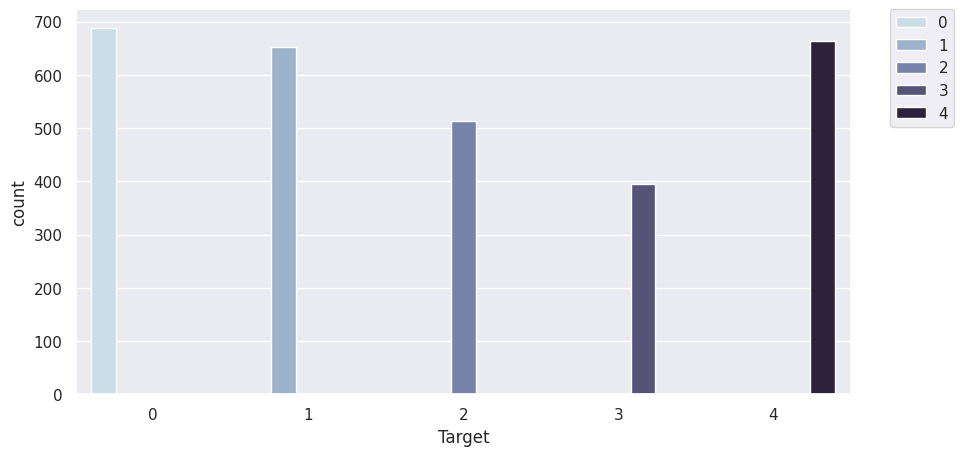

In [108]:
# Plot number of tweets in each target
sns.set(rc={'figure.figsize':(10, 5)})
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Target",hue='Target' ,data=data_train, palette="ch:s=.25,rot=-.25")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

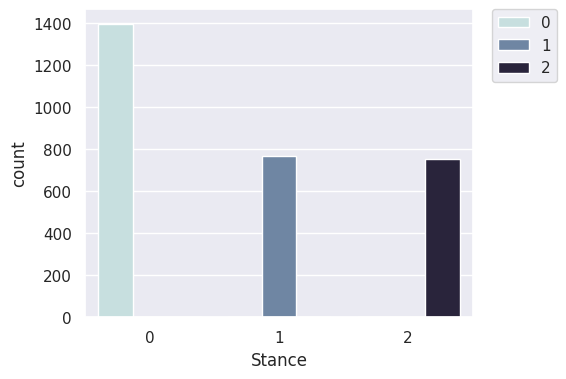

In [109]:
# Plot number of tweets in each stance
sns.set(rc={'figure.figsize':(5, 4)})
ax = sns.countplot(x='Stance',hue='Stance', data=data_train, palette="ch:start=.2,rot=-.3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Word Cloud For: Hillary Clinton




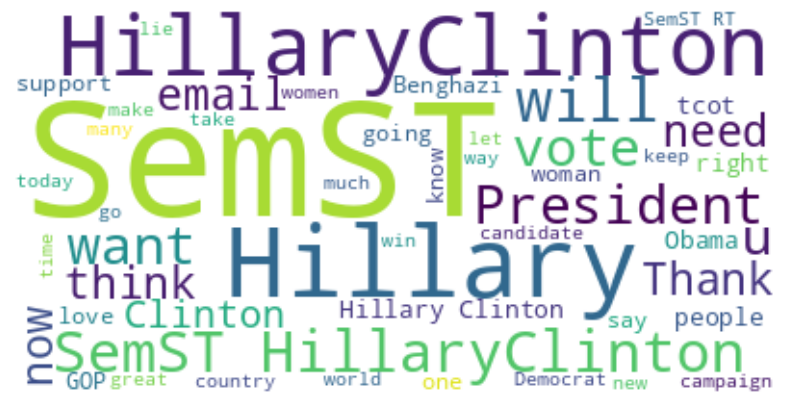



Word Cloud For: Legalization of Abortion




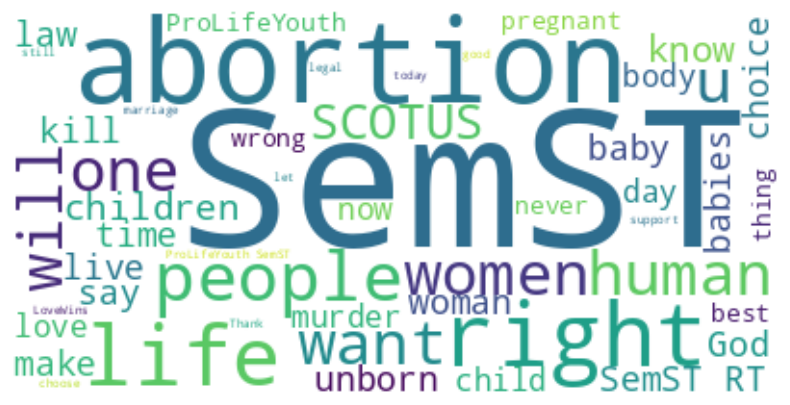



Word Cloud For: Atheism




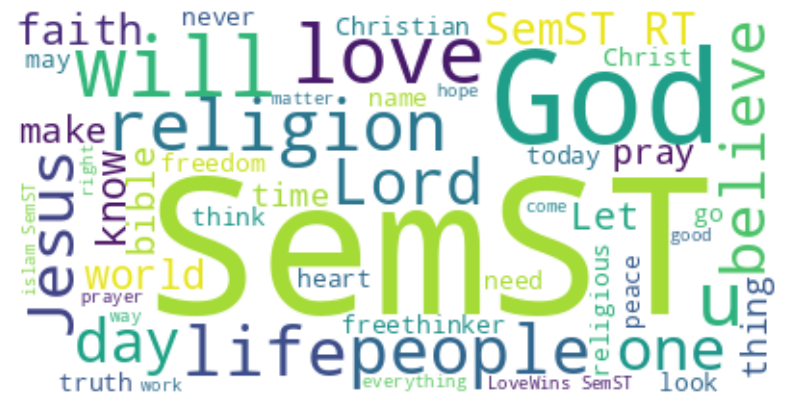



Word Cloud For: Climate Change is a Real Concern




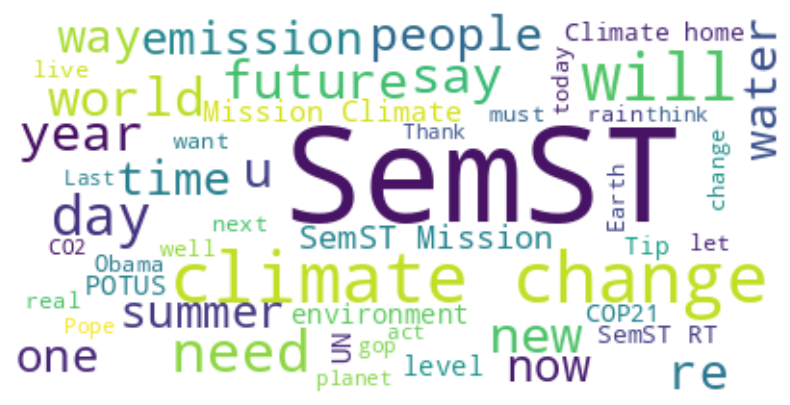



Word Cloud For: Feminist Movement




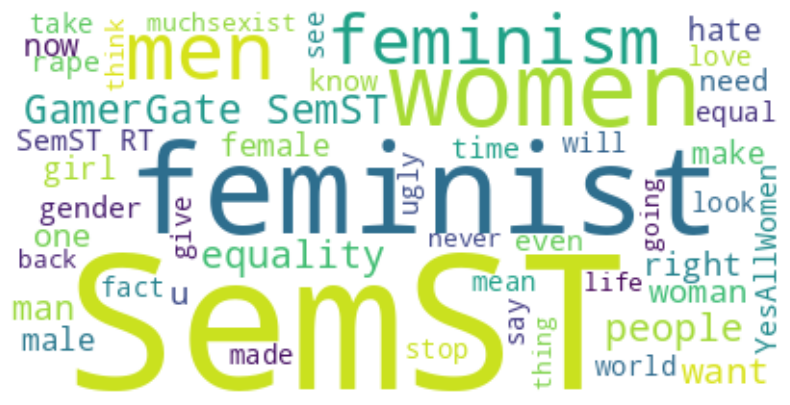

In [ ]:
# Visualise the most occuring words in each target
target_vals = data_train['Target'].unique()
for val in target_vals:
    tar_val = data_train.loc[data_train['Target']==val]
    all_target_val = " ".join(tar_val.Tweet.values)
    print("Word Cloud For:", val)
    print("\n")
    plot_word_cloud(all_target_val)
    print("\n")

In [ ]:
# Encode the target and stance to intgers for classification
encode_target = {
    "Hillary Clinton" : 0,
    "Legalization of Abortion"  : 1,
   "Atheism" : 2,
   "Climate Change is a Real Concern" : 3,
   "Feminist Movement"  : 4,
   "Donald Trump": 5
}
encode_stance = {
    "AGAINST" : 0,
    "FAVOR"  : 2,
    "NONE" : 1,
}

In [ ]:
!python -m spacy download en_core_web_sm

2023-11-27 21:24:36.972268: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-27 21:24:36.972348: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-27 21:24:36.972403: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-27 21:24:40.678199: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 39.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
def parallelize_dataframe(df, func, n_cores=4):
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [ ]:
# ddata_train = dd.from_pandas(data_train, npartitions=4)
# data_train['Tweet'] = ddata_train['Tweet'].map_partitions(lambda df: df.apply(tweet_data_preprocess)).compute(scheduler='processes')

# ddata_test = dd.from_pandas(data_test, npartitions=4)
# data_test['Tweet'] = ddata_test['Tweet'].map_partitions(lambda df: df.apply(tweet_data_preprocess)).compute(scheduler='processes')

In [ ]:
# # Apply preprocessing to the train and test data
# data_train['Tweet']  = data_train['Tweet'].apply(tweet_data_preprocess)
# data_test['Tweet']  = data_test['Tweet'].apply(tweet_data_preprocess)

In [ ]:
# print("Unique stances: ", data_train.Stance.unique())
# print("Unique targets: ", data_train.Target.unique())

In [ ]:
# # Encode the target and stance to integers for classification
# encoder = LabelEncoder()
# data_train["Stance"] = encoder.fit_transform(data_train["Stance"])
# data_train["Target"] = encoder.fit_transform(data_train["Target"])

In [ ]:
# data_train.to_csv('data_train.csv', index=False)
# data_test.to_csv('data_test.csv', index=False)

In [107]:
data_train = pd.read_csv('data_train.csv')
data_test = pd.read_csv('data_test.csv')

In [ ]:
data_train

,Tweet,Target,Stance,Opinion,Sentiment
0,wipe clean delete email explain dereliction du...,0,0,1. The tweet explicitly expresses opinion abo...,neg
1,hillary good choice truly want continue progre...,0,2,1. The tweet explicitly expresses opinion abo...,pos
2,think country ready female pre ever hillary,0,0,1. The tweet explicitly expresses opinion abo...,neg
3,give unhealthy amount hard earn money away big...,0,0,1. The tweet explicitly expresses opinion abo...,neg
4,thank add list,0,1,3. The tweet is not explicitly expressing opi...,pos
...,...,...,...,...,...
2909,law protect unborn eagle human idk notice bill...,1,0,1. The tweet explicitly expresses opinion abo...,neg
2910,abortion #abortionondemand #menstruationmatter...,1,0,2. The tweet does NOT expresses opinion about ...,other
2911,dare say sexual preference choice dare say dis...,1,0,2. The tweet does NOT expresses opinion about ...,neg
2912,equal right bear way right yet bear #liberallo...,1,0,2. The tweet does NOT expresses opinion about ...,neg


In [ ]:
data_test

,Tweet,Target,Stance,Opinion,Sentiment
0,exalt shall humble humble shall exalt matt #semst,Atheism,0,1. The tweet explicitly expresses opinion abo...,pos
1,remove nehushtan previous move god become idol...,Atheism,0,1. The tweet explicitly expresses opinion abo...,other
2,seek truth soul find strong enough stand merit...,Atheism,0,1. The tweet explicitly expresses opinion abo...,pos
3,utterly powerless without human intervention #...,Atheism,0,1. The tweet explicitly expresses opinion abo...,neg
4,miracle miracle shady #multiculturalism #taqiy...,Atheism,0,2. The tweet does NOT expresses opinion about ...,neg
...,...,...,...,...,...
1951,want next president tell spineless politician ...,Donald Trump,2,1. The tweet explicitly expresses opinion abo...,pos
1952,join twitter trump brigade support message #on...,Donald Trump,2,1. The tweet explicitly expresses opinion abo...,pos
1953,join twitter trump brigade support message #on...,Donald Trump,2,1. The tweet explicitly expresses opinion abo...,pos
1954,trump outlandish statement political strategy ...,Donald Trump,0,1. The tweet explicitly expresses opinion abo...,neg


### Integral

In [ ]:
d_test = data_test[data_test['Target'] == "Donald Trump"]
d_test

,Tweet,Target,Stance,Opinion,Sentiment
1249,blindly support political party willfull ignor...,Donald Trump,1,2. The tweet does NOT expresses opinion about ...,neg
1250,totally agree time get twitter peanut gallery ...,Donald Trump,1,2. The tweet does NOT expresses opinion about ...,pos
1251,fully support full repeal work candidate belie...,Donald Trump,1,2. The tweet does NOT expresses opinion about ...,pos
1252,stupid stupid showedhis true color seem ignore...,Donald Trump,0,1. The tweet explicitly expresses opinion abo...,neg
1253,one political party socialist party believe an...,Donald Trump,1,2. The tweet does NOT expresses opinion about ...,neg
...,...,...,...,...,...
1951,want next president tell spineless politician ...,Donald Trump,2,1. The tweet explicitly expresses opinion abo...,pos
1952,join twitter trump brigade support message #on...,Donald Trump,2,1. The tweet explicitly expresses opinion abo...,pos
1953,join twitter trump brigade support message #on...,Donald Trump,2,1. The tweet explicitly expresses opinion abo...,pos
1954,trump outlandish statement political strategy ...,Donald Trump,0,1. The tweet explicitly expresses opinion abo...,neg


In [ ]:
data_test = data_test[:1249]
data_test

,Tweet,Target,Stance,Opinion,Sentiment
0,exalt shall humble humble shall exalt matt #semst,Atheism,0,1. The tweet explicitly expresses opinion abo...,pos
1,remove nehushtan previous move god become idol...,Atheism,0,1. The tweet explicitly expresses opinion abo...,other
2,seek truth soul find strong enough stand merit...,Atheism,0,1. The tweet explicitly expresses opinion abo...,pos
3,utterly powerless without human intervention #...,Atheism,0,1. The tweet explicitly expresses opinion abo...,neg
4,miracle miracle shady #multiculturalism #taqiy...,Atheism,0,2. The tweet does NOT expresses opinion about ...,neg
...,...,...,...,...,...
1244,follow watch human centipede hope never make a...,Legalization of Abortion,1,2. The tweet does NOT expresses opinion about ...,neg
1245,avenge blood remember ignore cry afflicted #co...,Legalization of Abortion,0,1. The tweet explicitly expresses opinion abo...,other
1246,life sacre level abortion compute philosophy k...,Legalization of Abortion,0,1. The tweet explicitly expresses opinion abo...,other
1247,refer minority idiot support #suicide #murder ...,Legalization of Abortion,0,1. The tweet explicitly expresses opinion abo...,neg


In [ ]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

In [ ]:
# # Use a larger batch size
# batch_size = 256

# # Use pre-trained word embeddings
# embeddings_index = {}
# f = open(os.path.join('glove.6B.100d.txt'))  # Load GloVe word embeddings
# for line in f:
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()

# embedding_matrix = np.zeros((len(word_index) + 1, 100))
# for word, i in word_index.items():
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         # words not found in embedding index will be all-zeros.
#         embedding_matrix[i] = embedding_vector

# # Use the pre-trained word embeddings in the model
# model = Sequential()
# model.add(Embedding(len(word_index) + 1,
#                             100,
#                             weights=[embedding_matrix],
#                             input_length=sequence_length,
#                             trainable=False))
# model.add(LSTM(128))
# model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(3, activation='softmax'))

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# # Train the model
# history = model.fit(X_train, to_categorical(y_train), epochs=10, batch_size=batch_size, validation_data=(X_val, to_categorical(y_val)), callbacks=[early_stop])

# # Use batch prediction
# y_pred = model.predict(X_test, batch_size=batch_size)

In [ ]:
# # Calculate F1 score
# f1 = f1_score(y_test, y_pred, average='macro')
# print("F1 Score: ", f1)

In [ ]:
# Define maximum number of words to consider as features
max_features = 5000
# Define sequence length
sequence_length = 200

# Prepare the tokenizer on the training data
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data_train['Tweet'].values)

# Convert the text to sequences
X = tokenizer.texts_to_sequences(data_train['Tweet'].values)
X = pad_sequences(X, maxlen=sequence_length)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, data_train['Stance'], test_size=0.2, random_state=1)

# Convert the text to sequences for testing data
X_test = tokenizer.texts_to_sequences(data_test['Tweet'].values)
X_test = pad_sequences(X_test, maxlen=sequence_length)
y_test = data_test['Stance']

In [ ]:
X_test

array([[   0,    0,    0, ..., 3336, 1772,    1],
       [   0,    0,    0, ...,  256, 1033,    1],
       [   0,    0,    0, ...,  265,  123,    1],
       ...,
       [   0,    0,    0, ..., 4396, 1568,    1],
       [   0,    0,    0, ...,  148,  187,    1],
       [   0,    0,    0, ...,   63,  169,    1]], dtype=int32)

In [ ]:
# "Donald Trump"
X_d_test = tokenizer.texts_to_sequences(d_test['Tweet'].values)
X_d_test = pad_sequences(X_d_test, maxlen=sequence_length)
y_d_test = d_test['Stance']

In [ ]:
X_d_test

array([[   0,    0,    0, ...,  745,  549,    1],
       [   0,    0,    0, ...,   25, 2548,    1],
       [   0,    0,    0, ...,    9,  152,    1],
       ...,
       [   0,    0,    0, ...,  773, 2457,    1],
       [   0,    0,    0, ...,  180, 1421,    1],
       [   0,    0,    0, ...,   95,  237,    1]], dtype=int32)

Epoch 1/10
19/19 [==============================] - 4s 61ms/step - loss: 1.1520 - accuracy: 0.4753 - val_loss: 1.1168 - val_accuracy: 0.4391
Epoch 2/10
19/19 [==============================] - 0s 19ms/step - loss: 1.0233 - accuracy: 0.5543 - val_loss: 1.1855 - val_accuracy: 0.5129
Epoch 3/10
19/19 [==============================] - 0s 27ms/step - loss: 0.9231 - accuracy: 0.7452 - val_loss: 1.4296 - val_accuracy: 0.5283
Epoch 4/10
19/19 [==============================] - 1s 36ms/step - loss: 0.8901 - accuracy: 0.8250 - val_loss: 1.6287 - val_accuracy: 0.5249


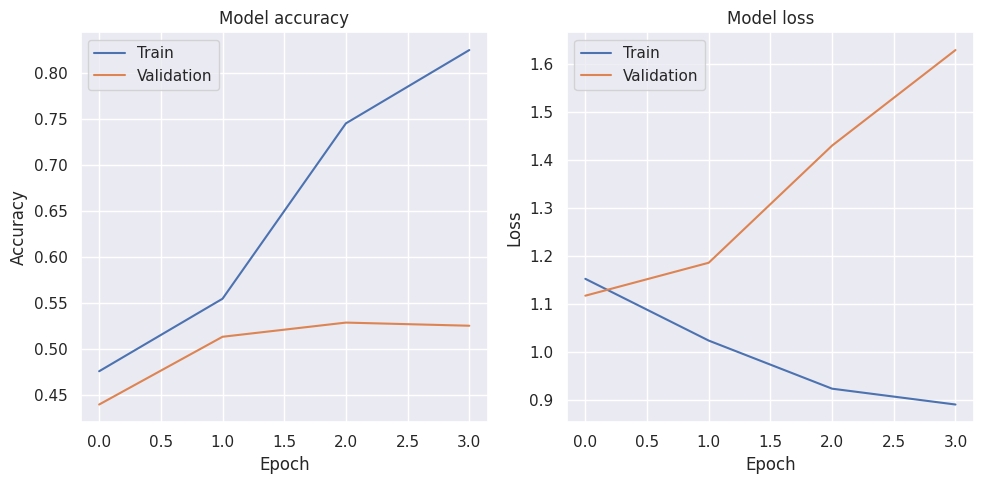

In [ ]:
# Define the model
# F1 Score:  0.58
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=64, embeddings_regularizer=l2(0.001)))  # Add L2 regularization to the Embedding layer
model.add(Dropout(0.5))  # Add dropout after the Embedding layer
model.add(LSTM(64, kernel_regularizer=l2(0.001)))  # Add L2 regularization to the LSTM layer
model.add(Dropout(0.5))  # Increase dropout rate
model.add(Dense(3, activation='softmax'))

# model = Sequential()
# model.add(Embedding(input_dim=5000, output_dim=64))
# model.add(LSTM(128))  # Use LSTM layer with 128 units
# model.add(Dropout(0.5))
# model.add(Dense(64, activation='relu'))  # Add an additional Dense layer
# model.add(Dropout(0.5))
# model.add(Dense(3, activation='softmax'))

# Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Use Adam optimizer with a learning rate of 0.01
model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)  # Stop training when the validation loss has not improved for 3 epochs

# Train the model and save the history
# history = model.fit(X_train, to_categorical(y_train), epochs=10, validation_data=(X_val, to_categorical(y_val)), callbacks=[early_stop])

# Use a batch size of 128
history = model.fit(X_train, to_categorical(y_train), epochs=10, batch_size=128, validation_data=(X_val, to_categorical(y_val)), callbacks=[early_stop])

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Test model
loss, accuracy = model.evaluate(X_test, to_categorical(y_test))
print("Test Accuracy: ", accuracy)

# Predict the stance for unseen data
y_pred = model.predict(X_test)

# Convert the predictions to class labels
y_pred = np.argmax(y_pred, axis=1)

40/40 [==============================] - 0s 8ms/step - loss: 1.5341 - accuracy: 0.5596
Test Accuracy:  0.5596477389335632
40/40 [==============================] - 1s 5ms/step


In [ ]:
# Test model
loss_d, accuracy_d = model.evaluate(X_d_test, to_categorical(y_d_test))
print("Test Accuracy: ", accuracy)

# Predict the stance for unseen data
y_d_pred = model.predict(X_d_test)

# Convert the predictions to class labels
y_d_pred = np.argmax(y_d_pred, axis=1)

23/23 [==============================] - 0s 6ms/step - loss: 1.9583 - accuracy: 0.3437
Test Accuracy:  0.5596477389335632
23/23 [==============================] - 0s 5ms/step


In [ ]:
# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='macro')
print("Initial F1 Score: ", f1)

Initial F1 Score:  0.5013317283209998


In [ ]:
# Calculate F1 score for "Donald Trump"
f1_d = f1_score(y_d_test, y_d_pred, average='macro')
print("Initial F1 Score: ", f1)

Initial F1 Score:  0.5216618832854995


In [ ]:
# Calculate F1 score
f1_all = f1_score(y_test, y_pred, average=None).reshape(1,-1)
f1_all = pd.DataFrame(f1_all, columns=['Against','None','Favor'], index=['Overall'])
print(f1_all)
score = (f1_all['Favor']+f1_all['Against'])/2

          Against      None     Favor
Overall  0.668571  0.402746  0.432678


In [ ]:
print("F1 Score: ", score.iloc[0])

F1 Score:  0.5506245947698293


In [ ]:
print(data_test['Target'].unique())

['Atheism' 'Climate Change is a Real Concern' 'Feminist Movement'
 'Hillary Clinton' 'Legalization of Abortion']


In [ ]:
# Calculate F1 score for "Donald Trump"
f1_d_all = f1_score(y_d_test, y_d_pred, average=None).reshape(1,-1)
f1_d_all = pd.DataFrame(f1_d_all,columns=['Against','None','Favor'], index=['Overall'])
print(f1_d_all)
score_d = (f1_d_all['Favor']+f1_d_all['Against'])/2

          Against      None    Favor
Overall  0.453577  0.304762  0.12069


In [ ]:
print("F1 Score for \"Donald Trump\": ", score_d.iloc[0])

F1 Score for "Donald Trump":  0.28713325985409116


In [ ]:
# Create a reverse mapping from integer codes to original target labels
decode_target = {v: k for k, v in encode_target.items()}

# Create a DataFrame to store the results for each target
results = pd.DataFrame(columns=['Target', 'F1_overall', 'F1_against', 'F1_none', 'F1_favor'])

# Now we can use the same split for both 'Stance' and 'Target'
targets = data_train['Target'].unique()
for target in targets:
    # Create a subset for the target
    data_train_target = data_train[data_train['Target'] == target]
    data_test_target = data_test[data_test['Target'] == decode_target[target]]  # Use the reverse mapping here

    # Determine the number of unique classes in the current subset
    num_classes_subset = len(np.unique(data_train_target['Stance']))

    # Convert the text to sequences
    X_train_target = tokenizer.texts_to_sequences(data_train_target['Tweet'].values)
    X_train_target = pad_sequences(X_train_target, maxlen=sequence_length)
    y_train_target = data_train_target['Stance']

    X_test_target = tokenizer.texts_to_sequences(data_test_target['Tweet'].values)
    X_test_target = pad_sequences(X_test_target, maxlen=sequence_length)
    y_test_target = data_test_target['Stance']

    # Check if the test set is empty
    if len(X_test_target) == 0 or len(y_test_target) == 0:
        print("No test data for target {}. Skipping...".format(target))
        continue

    # Define the model with the correct number of output nodes
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=64))
    model.add(LSTM(128))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes_subset, activation='softmax'))  # Use num_classes_subset instead of 3

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

    # Define early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=3)

    # Train the model
    history = model.fit(X_train_target, to_categorical(y_train_target, num_classes=num_classes_subset), epochs=10, batch_size=128, validation_data=(X_val, to_categorical(y_val, num_classes=num_classes_subset)), callbacks=[early_stop])

    # Test the model
    loss, accuracy = model.evaluate(X_test_target, to_categorical(y_test_target, num_classes=num_classes_subset))
    print("Test Accuracy for target {}: ".format(target), accuracy)

    # Predict the stance
    y_pred = model.predict(X_test_target)

    # Convert the predictions to class labels
    y_pred = np.argmax(y_pred, axis=1)

    # Calculate F1 score
    # f1 = f1_score(y_test_target, y_pred, average='macro')
    # print("F1 Score for target {}: ".format(target), f1)

    f1_all = f1_score(y_test_target, y_pred, average=None).reshape(1,-1)
    f1_all = pd.DataFrame(f1_all, columns=['Against','None', 'Favor'])
    print("F1 Score for target {}\n: ".format(target), f1_all)
    f1_overall = (f1_all['Favor']+f1_all['Against'])/2
    f1_overall = f1_overall.iloc[0]
    print("Overall F1: ", f1_overall)
    f1_overall

    # Add the results to the DataFrame
#     results = results.append({'Target': target, 'Accuracy': accuracy, 'F1 Score': f1}, ignore_index=True)
    new_row = pd.DataFrame({'Target': [target], 'F1_overall': f1_overall, 'F1_against':f1_all['Against'], 'F1_none':f1_all['None'], 'F1_favor':f1_all['Favor']})
    results = pd.concat([results, new_row], ignore_index=True)

Epoch 1/10
6/6 [==============================] - 6s 321ms/step - loss: 1.2945 - accuracy: 0.4848 - val_loss: 1.0825 - val_accuracy: 0.4391
Epoch 2/10
6/6 [==============================] - 1s 98ms/step - loss: 0.9998 - accuracy: 0.5646 - val_loss: 1.0563 - val_accuracy: 0.4528
Epoch 3/10
6/6 [==============================] - 1s 141ms/step - loss: 0.8859 - accuracy: 0.5864 - val_loss: 1.0928 - val_accuracy: 0.4768
Epoch 4/10
6/6 [==============================] - 1s 133ms/step - loss: 0.6583 - accuracy: 0.7228 - val_loss: 1.2594 - val_accuracy: 0.4408
Epoch 5/10
10/10 [==============================] - 0s 9ms/step - loss: 1.1909 - accuracy: 0.5593
Test Accuracy for target 0:  0.5593220591545105
10/10 [==============================] - 0s 7ms/step
F1 Score for target 0
:      Against      None     Favor
0  0.693767  0.426667  0.140845
Overall F1:  0.41730600404595597
Epoch 1/10
6/6 [==============================] - 5s 325ms/step - loss: 1.1322 - accuracy: 0.5023 - val_loss: 1.0640 - v

In [ ]:
# Convert the target variable back to original labels
results['Target'] = results['Target'].apply(lambda x: decode_target[int(x)])
results

,Target,F1_overall,F1_against,F1_none,F1_favor
0,Hillary Clinton,0.417306,0.693767,0.426667,0.140845
1,Legalization of Abortion,0.566562,0.715543,0.484375,0.417582
2,Atheism,0.421053,0.842105,0.000000,0.000000
3,Climate Change is a Real Concern,0.414545,0.000000,0.269231,0.829091
4,Feminist Movement,0.498142,0.606811,0.245614,0.389474


### Divided

In [7]:
data_train = pd.read_csv('data_train.csv')
data_test = pd.read_csv('data_test.csv')

In [8]:
# Hillary Clinton
h_train = data_train[data_train['Target'] == 0]
h_test = data_test[data_test['Target'] == 'Hillary Clinton']

# Legalization of Abortion
l_train = data_train[data_train['Target'] == 1]
l_test = data_test[data_test['Target'] == 'Legalization of Abortion']

# Atheism
a_train = data_train[data_train['Target'] == 2]
a_test = data_test[data_test['Target'] == 'Atheism']

# Climate Change is a Real Concern
c_train = data_train[data_train['Target'] == 3]
c_test = data_test[data_test['Target'] == 'Climate Change is a Real Concern']

# Feminist Movement
f_train = data_train[data_train['Target'] == 4]
f_test = data_test[data_test['Target'] == 'Feminist Movement']

In [9]:
d_test = data_test[data_test['Target'] == "Donald Trump"]

In [10]:
# Encode the target and stance to intgers for classification
encode_target = {
    "Hillary Clinton" : 0,
    "Legalization of Abortion"  : 1,
   "Atheism" : 2,
   "Climate Change is a Real Concern" : 3,
   "Feminist Movement"  : 4,
  #  "Donald Trump": 5
}
encode_stance = {
    "AGAINST" : 0,
    "FAVOR"  : 2,
    "NONE" : 1,
}

In [11]:
def predict(data_train):
  # Define maximum number of words to consider as features
  max_features = 5000
  # Define sequence length
  sequence_length = 200

  # Prepare the tokenizer on the training data
  tokenizer = Tokenizer(num_words=max_features, split=' ')
  tokenizer.fit_on_texts(data_train['Tweet'].values)

  # Convert the text to sequences
  X = tokenizer.texts_to_sequences(data_train['Tweet'].values)
  X = pad_sequences(X, maxlen=sequence_length)

  # Split the data into training and validation sets
  X_train, X_val, y_train, y_val = train_test_split(X, data_train['Stance'], test_size=0.2, random_state=1)

  # Convert the text to sequences for testing data
  X_test = tokenizer.texts_to_sequences(data_test['Tweet'].values)
  X_test = pad_sequences(X_test, maxlen=sequence_length)
  y_test = data_test['Stance']

  # "Donald Trump"
  X_d_test = tokenizer.texts_to_sequences(d_test['Tweet'].values)
  X_d_test = pad_sequences(X_d_test, maxlen=sequence_length)
  y_d_test = d_test['Stance']

  # Define the model
  model = Sequential()
  model.add(Embedding(input_dim=5000, output_dim=64, embeddings_regularizer=l2(0.001)))  # Add L2 regularization to the Embedding layer
  model.add(Dropout(0.5))  # Add dropout after the Embedding layer
  model.add(LSTM(64, kernel_regularizer=l2(0.001)))  # Add L2 regularization to the LSTM layer
  model.add(Dropout(0.5))  # Increase dropout rate
  model.add(Dense(3, activation='softmax'))

  # model = Sequential()
  # model.add(Embedding(input_dim=5000, output_dim=64))
  # model.add(LSTM(128))  # Use LSTM layer with 128 units
  # model.add(Dropout(0.5))
  # model.add(Dense(64, activation='relu'))  # Add an additional Dense layer
  # model.add(Dropout(0.5))
  # model.add(Dense(3, activation='softmax'))

  # Compile the model
  # model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  # Use Adam optimizer with a learning rate of 0.01
  model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

  # Define early stopping
  early_stop = EarlyStopping(monitor='val_loss', patience=3)  # Stop training when the validation loss has not improved for 3 epochs

  # Train the model and save the history
  # history = model.fit(X_train, to_categorical(y_train), epochs=10, validation_data=(X_val, to_categorical(y_val)), callbacks=[early_stop])

  # Use a batch size of 128
  history = model.fit(X_train, to_categorical(y_train), epochs=10, batch_size=128, validation_data=(X_val, to_categorical(y_val)), callbacks=[early_stop])


  loss, accuracy = model.evaluate(X_test, to_categorical(y_test))
  print("Test Accuracy: ", accuracy)

  # Predict the stance for unseen data
  y_x_pred = model.predict(X_test)

  # Convert the predictions to class labels
  y_x_pred = np.argmax(y_x_pred, axis=1)


  # Test model
  loss_d, accuracy_d = model.evaluate(X_d_test, to_categorical(y_d_test))
  print("Test Accuracy for \"Donald Trump\": ", accuracy)

  # Predict the stance for unseen data
  y_d_pred = model.predict(X_d_test)

  # Convert the predictions to class labels
  y_d_pred = np.argmax(y_d_pred, axis=1)

  # Calculate F1 score
  f1_all = f1_score(y_test, y_x_pred, average=None).reshape(1,-1)
  f1_all = pd.DataFrame(f1_all, columns=['Against','None','Favor'])
  f1_overall = (f1_all['Favor']+f1_all['Against'])/2
  f1_overall = f1_overall.iloc[0]

  f1_d_all = f1_score(y_d_test, y_d_pred, average=None).reshape(1,-1)
  f1_d_all = pd.DataFrame(f1_d_all,columns=['Against','None','Favor'])
  score_d = (f1_d_all['Favor']+f1_d_all['Against'])/2
  score_d = score_d.iloc[0]

  # Add the results to the DataFrame
  result = pd.DataFrame(columns=['F1_average', 'F1_against', 'F1_none', 'F1_favor'])
  new_row = pd.DataFrame({'F1_average': f1_overall, 'F1_against':f1_all['Against'], 'F1_none':f1_all['None'], 'F1_favor':f1_all['Favor']})
  result = pd.concat([result, new_row], ignore_index=True)
  print("F1 Overall:\n", result)

  result_d = pd.DataFrame(columns=['F1_average', 'F1_against', 'F1_none', 'F1_favor'])
  new_row_d = pd.DataFrame({'F1_average': score_d, 'F1_against':f1_d_all['Against'], 'F1_none':f1_d_all['None'], 'F1_favor':f1_d_all['Favor']})
  result_d = pd.concat([result_d, new_row_d], ignore_index=True)
  print("F1 Overall:\n", result_d)

  # Create a reverse mapping from integer codes to original target labels
  decode_target = {v: k for k, v in encode_target.items()}

  # Create a DataFrame to store the results for each target
  results = pd.DataFrame(columns=['Target', 'F1_overall', 'F1_against', 'F1_none', 'F1_favor'])

  # Now we can use the same split for both 'Stance' and 'Target'
  targets = data_train['Target'].unique()
  for target in targets:
      # Create a subset for the target
      data_train_target = data_train[data_train['Target'] == target]
      data_test_target = data_test[data_test['Target'] == decode_target[target]]  # Use the reverse mapping here

      # Determine the number of unique classes in the current subset
      num_classes_subset = len(np.unique(data_train_target['Stance']))

      # Convert the text to sequences
      X_train_target = tokenizer.texts_to_sequences(data_train_target['Tweet'].values)
      X_train_target = pad_sequences(X_train_target, maxlen=sequence_length)
      y_train_target = data_train_target['Stance']

      X_test_target = tokenizer.texts_to_sequences(data_test_target['Tweet'].values)
      X_test_target = pad_sequences(X_test_target, maxlen=sequence_length)
      y_test_target = data_test_target['Stance']

      # Check if the test set is empty
      if len(X_test_target) == 0 or len(y_test_target) == 0:
          print("No test data for target {}. Skipping...".format(target))
          continue

      # Define the model with the correct number of output nodes
      model = Sequential()
      model.add(Embedding(input_dim=5000, output_dim=64))
      model.add(LSTM(128))
      model.add(Dropout(0.5))
      model.add(Dense(64, activation='relu'))
      model.add(Dropout(0.5))
      model.add(Dense(num_classes_subset, activation='softmax'))  # Use num_classes_subset instead of 3

      # Compile the model
      model.compile(optimizer=Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

      # Define early stopping
      early_stop = EarlyStopping(monitor='val_loss', patience=3)

      # Train the model
      history = model.fit(X_train_target, to_categorical(y_train_target, num_classes=num_classes_subset), epochs=10, batch_size=128, validation_data=(X_val, to_categorical(y_val, num_classes=num_classes_subset)), callbacks=[early_stop])

      # Test the model
      loss, accuracy = model.evaluate(X_test_target, to_categorical(y_test_target, num_classes=num_classes_subset))
      print("Test Accuracy for target {}: ".format(target), accuracy)

      # Predict the stance
      y_pred = model.predict(X_test_target)

      # Convert the predictions to class labels
      y_pred = np.argmax(y_pred, axis=1)

      # Calculate F1 score
      # f1 = f1_score(y_test_target, y_pred, average='macro')
      # print("F1 Score for target {}: ".format(target), f1)

      f1_all = f1_score(y_test_target, y_pred, average=None).reshape(1,-1)
      f1_all = pd.DataFrame(f1_all, columns=['Against','None','Favor'])
      print("F1 Score for target {}\n: ".format(target), f1_all)
      f1_overall = (f1_all['Favor']+f1_all['Against'])/2
      f1_overall = f1_overall.iloc[0]
      print("Overall F1: ", f1_overall)
      f1_overall

      # Add the results to the DataFrame
      new_row = pd.DataFrame({'Target': [target], 'F1_overall': f1_overall, 'F1_against':f1_all['Against'], 'F1_none':f1_all['None'], 'F1_favor':f1_all['Favor']})
      results = pd.concat([results, new_row], ignore_index=True)
      results['Target'] = results['Target'].apply(lambda x: decode_target[int(x)])

  return y_test, y_x_pred, y_pred, result, results, result_d, score_d

In [58]:
# y_h_test, y_overall_h_pred, y_h_pred, h_result, h_results, h_d_result, h_d_avef1= predict(h_train)
# y_l_test, y_overall_l_pred, y_l_pred, l_result, l_results, l_d_result, l_d_avef1= predict(l_train)
# y_a_test, y_overall_a_pred, y_a_pred, a_result, a_results, a_d_result, a_d_avef1= predict(a_train)
# y_c_test, y_overall_c_pred, y_c_pred, c_result, c_results, c_d_result, c_d_avef1= predict(c_train)
# y_f_test, y_overall_f_pred, y_f_pred, f_result, f_results, f_d_result, f_d_avef1= predict(f_train)

In [83]:
y_h_test, y_overall_h_pred, y_h_pred, h_result, h_results, h_d_result, h_d_avef1= predict(h_train)

Epoch 1/10
5/5 [==============================] - 3s 153ms/step - loss: 1.3415 - accuracy: 0.4973 - val_loss: 1.0676 - val_accuracy: 0.5725
Epoch 2/10
5/5 [==============================] - 0s 29ms/step - loss: 1.0696 - accuracy: 0.5699 - val_loss: 1.0432 - val_accuracy: 0.5725
Epoch 3/10
5/5 [==============================] - 0s 29ms/step - loss: 0.9904 - accuracy: 0.5699 - val_loss: 0.9960 - val_accuracy: 0.5725
Epoch 4/10
5/5 [==============================] - 0s 26ms/step - loss: 0.8407 - accuracy: 0.6407 - val_loss: 0.9658 - val_accuracy: 0.6232
Epoch 5/10
5/5 [==============================] - 0s 26ms/step - loss: 0.6561 - accuracy: 0.8149 - val_loss: 1.1516 - val_accuracy: 0.6232
Epoch 6/10
5/5 [==============================] - 0s 23ms/step - loss: 0.4994 - accuracy: 0.9147 - val_loss: 1.2799 - val_accuracy: 0.5507
Epoch 7/10
62/62 [==============================] - 0s 6ms/step - loss: 1.8298 - accuracy: 0.4197
Test Accuracy:  0.4197341501712799
23/23 [=========================

In [84]:
print(h_result)
print(h_results)
print("\nFor \"Donald Trump\"")
print(h_d_result)
print(h_d_avef1)

   F1_average  F1_against   F1_none  F1_favor
0    0.324054    0.545545  0.359584  0.102564
            Target  F1_overall  F1_against   F1_none  F1_favor
0  Hillary Clinton    0.518815    0.647799  0.441558  0.389831

For "Donald Trump"
   F1_average  F1_against   F1_none  F1_favor
0    0.272422    0.453416  0.420168  0.091429
0.2724223602484472


In [85]:
h_average = h_results['F1_overall'].iloc[0]
h_favor = h_results['F1_favor'].iloc[0]
h_against = h_results['F1_against'].iloc[0]

In [61]:
y_l_test, y_overall_l_pred, y_l_pred, l_result, l_results, l_d_result, l_d_avef1= predict(l_train)

Epoch 1/10
5/5 [==============================] - 4s 304ms/step - loss: 1.3071 - accuracy: 0.5038 - val_loss: 1.0816 - val_accuracy: 0.6031
Epoch 2/10
5/5 [==============================] - 0s 34ms/step - loss: 1.0695 - accuracy: 0.5287 - val_loss: 0.9892 - val_accuracy: 0.6031
Epoch 3/10
5/5 [==============================] - 0s 41ms/step - loss: 0.9006 - accuracy: 0.5939 - val_loss: 0.9289 - val_accuracy: 0.6489
Epoch 4/10
5/5 [==============================] - 0s 43ms/step - loss: 0.6401 - accuracy: 0.8563 - val_loss: 1.2151 - val_accuracy: 0.6718
Epoch 5/10
5/5 [==============================] - 0s 41ms/step - loss: 0.5236 - accuracy: 0.9100 - val_loss: 1.4373 - val_accuracy: 0.6336
Epoch 6/10
62/62 [==============================] - 1s 9ms/step - loss: 1.8425 - accuracy: 0.3604
Test Accuracy:  0.36042943596839905
23/23 [==============================] - 0s 5ms/step - loss: 1.8872 - accuracy: 0.3437
Test Accuracy for "Donald Trump":  0.36042943596839905
23/23 [=====================

In [62]:
print(l_result)
print(l_results)
print("\nFor \"Donald Trump\"")
print(l_d_result)
print(l_d_avef1)

   F1_average  F1_against   F1_none  F1_favor
0    0.246933    0.370842  0.422798  0.123023
                     Target  F1_overall  F1_against   F1_none  F1_favor
0  Legalization of Abortion    0.593041    0.735632  0.435644   0.45045

For "Donald Trump"
   F1_average  F1_against   F1_none  F1_favor
0    0.075181    0.115068  0.498294  0.035294
0.07518130539887188


In [86]:
l_average = l_results['F1_overall'].iloc[0]
l_favor = l_results['F1_favor'].iloc[0]
l_against = l_results['F1_against'].iloc[0]

In [63]:
y_a_test, y_overall_a_pred, y_a_pred, a_result, a_results, a_d_result, a_d_avef1= predict(a_train)

Epoch 1/10
4/4 [==============================] - 3s 183ms/step - loss: 1.3037 - accuracy: 0.4610 - val_loss: 1.0333 - val_accuracy: 0.6602
Epoch 2/10
4/4 [==============================] - 0s 28ms/step - loss: 1.0433 - accuracy: 0.5756 - val_loss: 0.9265 - val_accuracy: 0.6602
Epoch 3/10
4/4 [==============================] - 0s 28ms/step - loss: 0.9382 - accuracy: 0.5756 - val_loss: 0.8816 - val_accuracy: 0.6505
Epoch 4/10
4/4 [==============================] - 0s 32ms/step - loss: 0.6815 - accuracy: 0.7537 - val_loss: 3.2418 - val_accuracy: 0.6602
Epoch 5/10
4/4 [==============================] - 0s 26ms/step - loss: 2.2915 - accuracy: 0.6415 - val_loss: 0.9728 - val_accuracy: 0.6893
Epoch 6/10
62/62 [==============================] - 1s 8ms/step - loss: 1.4808 - accuracy: 0.3584
Test Accuracy:  0.35838446021080017
23/23 [==============================] - 0s 7ms/step - loss: 1.4631 - accuracy: 0.3692
Test Accuracy for "Donald Trump":  0.35838446021080017
23/23 [=====================

In [64]:
print(a_result)
print(a_results)
print("\nFor \"Donald Trump\"")
print(a_d_result)
print(a_d_avef1)

   F1_average  F1_against   F1_none  F1_favor
0    0.228943    0.389751  0.409326  0.068136
    Target  F1_overall  F1_against   F1_none  F1_favor
0  Atheism     0.54447    0.737589  0.404762  0.351351

For "Donald Trump"
   F1_average  F1_against   F1_none  F1_favor
0    0.133104    0.240566  0.498801  0.025641
0.13310353168843733


In [87]:
a_average = a_results['F1_overall'].iloc[0]
a_favor = a_results['F1_favor'].iloc[0]
a_against = a_results['F1_against'].iloc[0]

In [65]:
y_c_test, y_overall_c_pred, y_c_pred, c_result, c_results, c_d_result, c_d_avef1= predict(c_train)

Epoch 1/10
3/3 [==============================] - 3s 358ms/step - loss: 1.3014 - accuracy: 0.3987 - val_loss: 1.0746 - val_accuracy: 0.3797
Epoch 2/10
3/3 [==============================] - 0s 40ms/step - loss: 1.1126 - accuracy: 0.4557 - val_loss: 0.8786 - val_accuracy: 0.5823
Epoch 3/10
3/3 [==============================] - 0s 46ms/step - loss: 0.9394 - accuracy: 0.5348 - val_loss: 0.9065 - val_accuracy: 0.6582
Epoch 4/10
3/3 [==============================] - 0s 46ms/step - loss: 0.8667 - accuracy: 0.6519 - val_loss: 0.8341 - val_accuracy: 0.6076
Epoch 5/10
3/3 [==============================] - 0s 49ms/step - loss: 0.7473 - accuracy: 0.7120 - val_loss: 0.8038 - val_accuracy: 0.6329
Epoch 6/10
3/3 [==============================] - 0s 42ms/step - loss: 0.5630 - accuracy: 0.8956 - val_loss: 0.7535 - val_accuracy: 0.7215
Epoch 7/10
3/3 [==============================] - 0s 43ms/step - loss: 0.4224 - accuracy: 0.9430 - val_loss: 0.8420 - val_accuracy: 0.7342
Epoch 8/10
3/3 [==========

In [66]:
print(c_result)
print(c_results)
print("\nFor \"Donald Trump\"")
print(c_d_result)
print(c_d_avef1)

   F1_average  F1_against   F1_none  F1_favor
0    0.181303         0.0  0.376496  0.362606
                             Target  F1_overall  F1_against  F1_none  F1_favor
0  Climate Change is a Real Concern    0.421233         0.0      0.0  0.842466

For "Donald Trump"
   F1_average  F1_against   F1_none  F1_favor
0    0.097264         0.0  0.473282  0.194529
0.09726443768996962


In [88]:
c_average = c_results['F1_overall'].iloc[0]
c_favor = c_results['F1_favor'].iloc[0]
c_against = c_results['F1_against'].iloc[0]

In [79]:
y_f_test, y_overall_f_pred, y_f_pred, f_result, f_results, f_d_result, f_d_avef1= predict(f_train)

Epoch 1/10
5/5 [==============================] - 3s 178ms/step - loss: 1.2753 - accuracy: 0.4313 - val_loss: 1.0873 - val_accuracy: 0.5489
Epoch 2/10
5/5 [==============================] - 0s 36ms/step - loss: 1.0798 - accuracy: 0.4802 - val_loss: 1.0501 - val_accuracy: 0.5489
Epoch 3/10
5/5 [==============================] - 0s 36ms/step - loss: 0.9466 - accuracy: 0.5593 - val_loss: 1.0408 - val_accuracy: 0.6090
Epoch 4/10
5/5 [==============================] - 0s 33ms/step - loss: 0.7482 - accuracy: 0.7458 - val_loss: 1.1833 - val_accuracy: 0.5414
Epoch 5/10
5/5 [==============================] - 0s 31ms/step - loss: 0.5839 - accuracy: 0.8267 - val_loss: 1.3190 - val_accuracy: 0.5338
Epoch 6/10
62/62 [==============================] - 1s 8ms/step - loss: 1.7493 - accuracy: 0.3323
Test Accuracy:  0.33231082558631897
23/23 [==============================] - 0s 7ms/step - loss: 1.8932 - accuracy: 0.2801
Test Accuracy for "Donald Trump":  0.33231082558631897
23/23 [=====================

In [80]:
print(f_result)
print(f_results)
print("\nFor \"Donald Trump\"")
print(f_d_result)
print(f_d_avef1)

   F1_average  F1_against   F1_none  F1_favor
0    0.344355    0.321244  0.279343  0.367466
              Target  F1_overall  F1_against   F1_none  F1_favor
0  Feminist Movement    0.546355    0.695652  0.314607  0.397059

For "Donald Trump"
   F1_average  F1_against   F1_none  F1_favor
0    0.269796    0.220513  0.278846  0.319079
0.26979588394062076


In [89]:
f_average = f_results['F1_overall'].iloc[0]
f_favor = f_results['F1_favor'].iloc[0]
f_against = f_results['F1_against'].iloc[0]

In [90]:
combine_pred = pd.concat([pd.DataFrame(y_a_pred), pd.DataFrame(y_c_pred)], ignore_index=True)
combine_pred = pd.concat([pd.DataFrame(combine_pred), pd.DataFrame(y_f_pred)], ignore_index=True)
combine_pred = pd.concat([pd.DataFrame(combine_pred), pd.DataFrame(y_h_pred)], ignore_index=True)
combine_pred = pd.concat([pd.DataFrame(combine_pred), pd.DataFrame(y_l_pred)], ignore_index=True)
combine_pred

,0
0,0
1,0
2,0
3,2
4,0
...,...
1244,0
1245,1
1246,0
1247,0


In [91]:
data_test = pd.read_csv('data_test.csv')
target_test = data_test[:1249]

In [92]:
f1_all = f1_score(pd.DataFrame(target_test['Stance']), combine_pred, average=None).reshape(1,-1)
f1_all = pd.DataFrame(f1_all, columns=['Against','None','Favor'])
print(f1_all)
f1_overall = (f1_all['Favor']+f1_all['Against'])/2
f1_overall = f1_overall.iloc[0]
print(f1_overall)

    Against     None     Favor
0  0.697853  0.37581  0.577291
0.6375720712025714
